In [45]:
# Auto reload modules
%load_ext autoreload
%autoreload all

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter, get_common_distributions
from IPython.utils import io
import numpy as np
import os
from scipy.stats import skew, kurtosis

from plot_distribution import distribution

distributions = [
    "gamma",
    "norm",
    "lognorm",
    "expon",
    "beta",
    "weibull_min",
    "cauchy",
    "exponpow",
    "chi2",
]

In [47]:

# Create a directory for plots if it doesn't exist
if not os.path.exists("plots"):
    os.makedirs("plots")

# Load the data
try:
    df = pd.read_csv("pst_to_GIc_with_const_wl.csv")
except FileNotFoundError:
    print("pst_to_GIc_with_const_wl.csv not found. Please run 1_eval_pst.py first.")
    exit()

print("Data loaded successfully. Starting analysis...")
print(df.info())
print(df.head())

# Remove unphysical rho values
df = df[df["rho_wl"] >= 50]

Data loaded successfully. Starting analysis...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445 entries, 0 to 2444
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   file_path      2445 non-null   object 
 1   pst_id         2445 non-null   int64  
 2   column_length  2445 non-null   float64
 3   cut_length     2445 non-null   float64
 4   phi            2445 non-null   float64
 5   cut_depth      2445 non-null   float64
 6   rho_wl         2445 non-null   float64
 7   E_wl           2445 non-null   float64
 8   HH_wl          2435 non-null   object 
 9   GT_wl          2327 non-null   object 
 10  GS_wl          1816 non-null   float64
 11  G              2445 non-null   float64
 12  GIc            2445 non-null   float64
 13  GIIc           2445 non-null   float64
dtypes: float64(10), int64(1), object(3)
memory usage: 267.5+ KB
None
                                          file_path  pst_id  column_leng

In [48]:
# Stats
mean = df["GIc"].mean()
std = df["GIc"].std()
skew = skew(df["GIc"])
kurt = kurtosis(df["GIc"])
print(f"Mean: {mean:.3f}, Std: {std:.3f}, Skew: {skew:.3f}, Kurt: {kurt:.3f}")

Mean: 0.721, Std: 1.133, Skew: 4.461, Kurt: 29.600


## Analyze the data


Fitting distributions to GIc...
Best distributions for GIc:
             sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm             0.112762  1068.985450 -24377.157395     inf      0.016424   
weibull_min         0.201126  1328.799145 -22962.942456     inf      0.063481   
chi2                0.268681  1548.165709 -22255.175618     inf      0.080137   
beta                0.318225  1590.306578 -21833.763502     inf      0.089980   
expon               0.472734  1778.500777 -20882.098172     inf      0.129382   

                ks_pvalue  
lognorm      5.194283e-01  
weibull_min  5.262582e-09  
chi2         4.234032e-14  
beta         1.143583e-17  
expon        3.958290e-36  


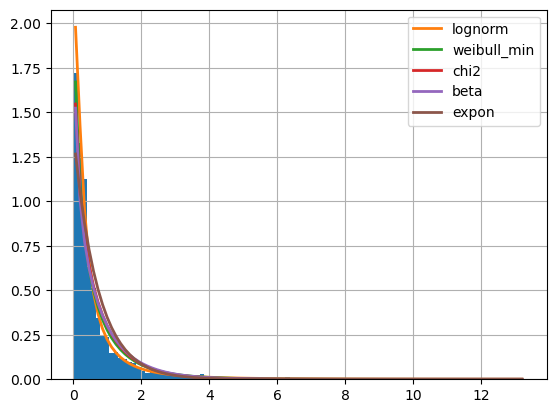

In [49]:
# Fit distributions to GIc
print("\nFitting distributions to GIc...")
g_ic_fitter = Fitter(
    df["GIc"].dropna(),
    distributions=distributions,
)
with io.capture_output() as captured:
    g_ic_fitter.fit()
print("Best distributions for GIc:")
summary = g_ic_fitter.summary()
print(summary)

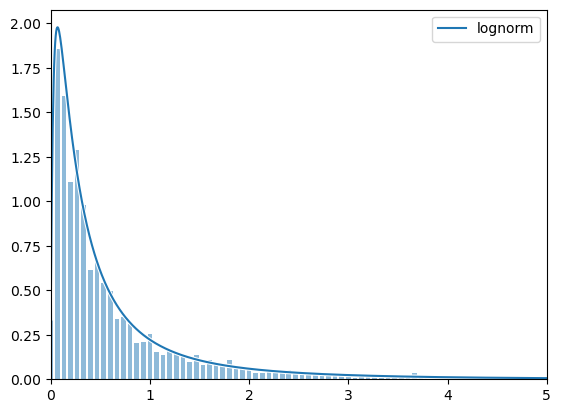

In [50]:
# Distribution of GIc
distribution(
    df["GIc"],
    dist_type="lognorm",
    kind="pdf",
    bins=75,
    plot_range=(0, 5),
    save="plots/GIc_pdf.png",
)

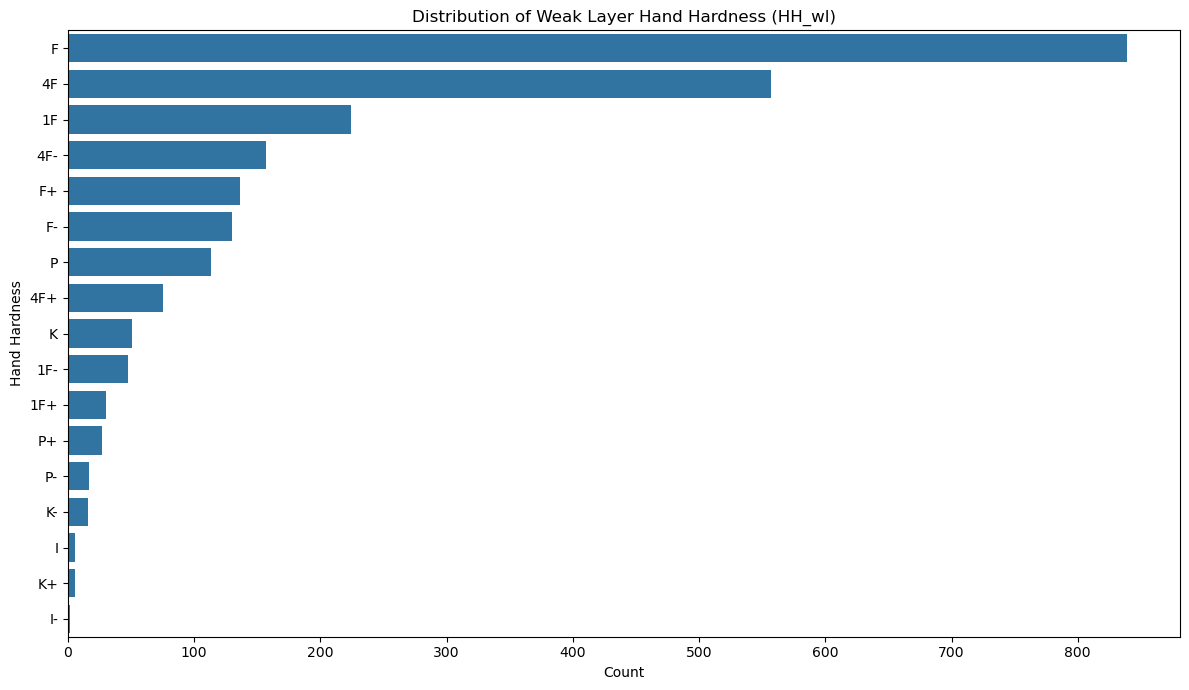

In [51]:
# Distribution of HH_wl (Hand Hardness) (8 string entries)
plt.figure(figsize=(12, 7))
sns.countplot(y=df["HH_wl"], order=df["HH_wl"].value_counts().index)
plt.title("Distribution of Weak Layer Hand Hardness (HH_wl)")
plt.xlabel("Count")
plt.ylabel("Hand Hardness")
plt.tight_layout()

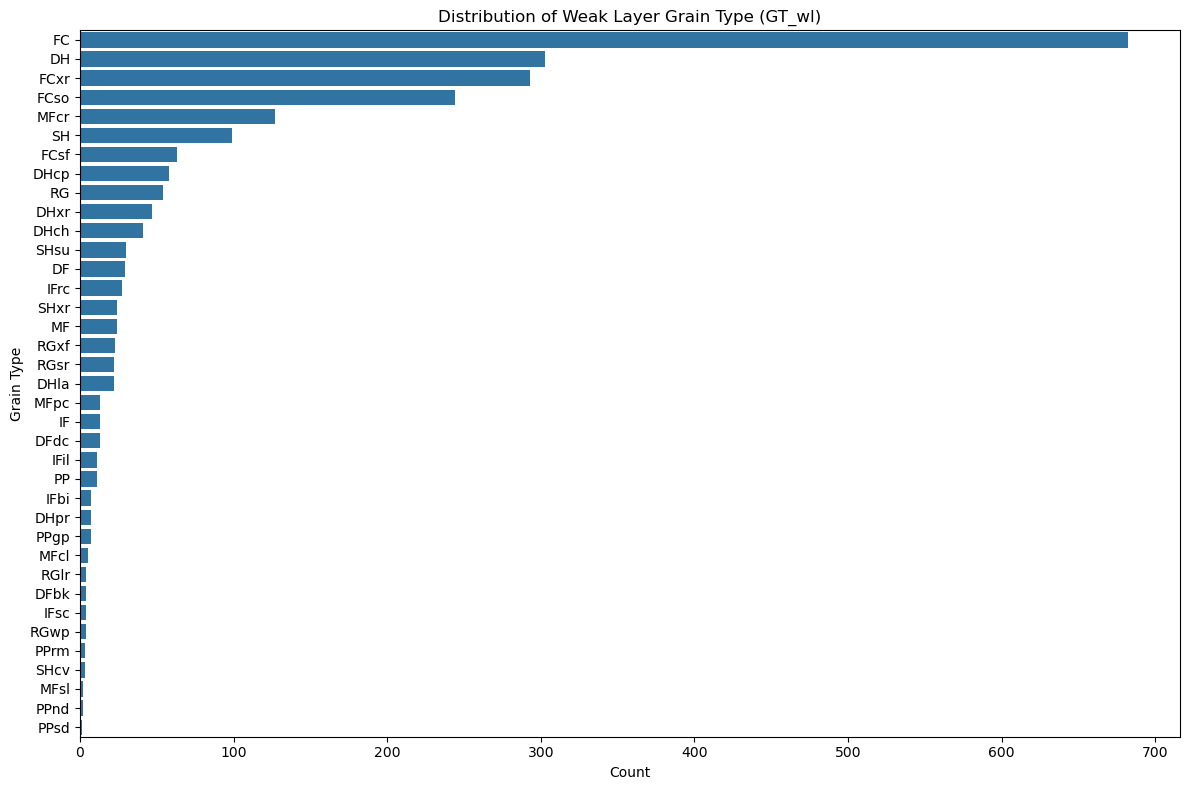

In [52]:

# Distribution of GT_wl (Grain Type)
plt.figure(figsize=(12, 8))
sns.countplot(y=df["GT_wl"], order=df["GT_wl"].value_counts().index)
plt.title("Distribution of Weak Layer Grain Type (GT_wl)")
plt.xlabel("Count")
plt.ylabel("Grain Type")
plt.tight_layout()


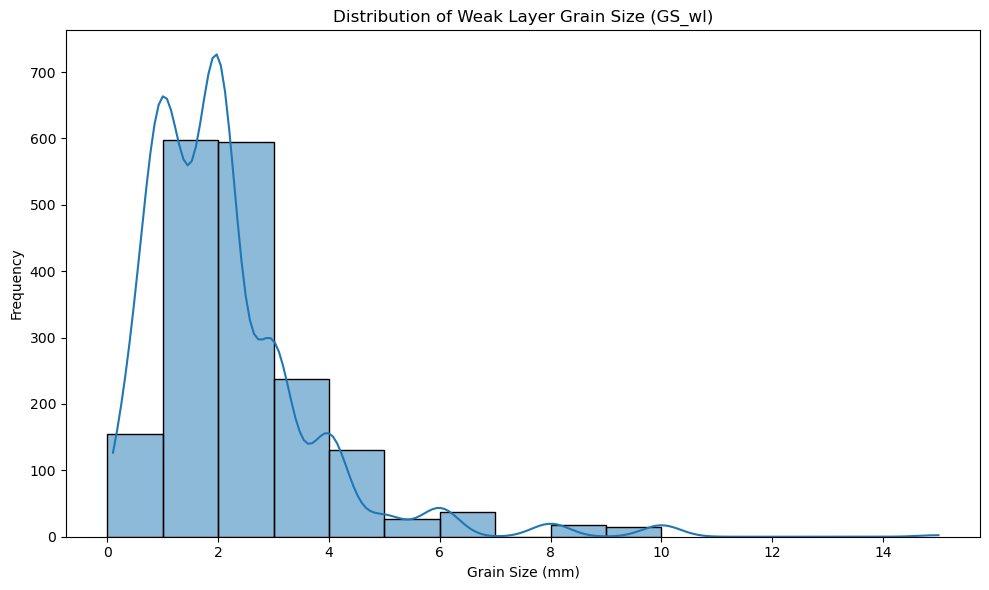

In [53]:
# Distribution of GS_wl (Grain Size)
plt.figure(figsize=(10, 6))
sns.histplot(df["GS_wl"], kde=True, bins=10, binrange=(0, 10))
plt.title("Distribution of Weak Layer Grain Size (GS_wl)")
plt.xlabel("Grain Size (mm)")
plt.ylabel("Frequency")
plt.tight_layout()

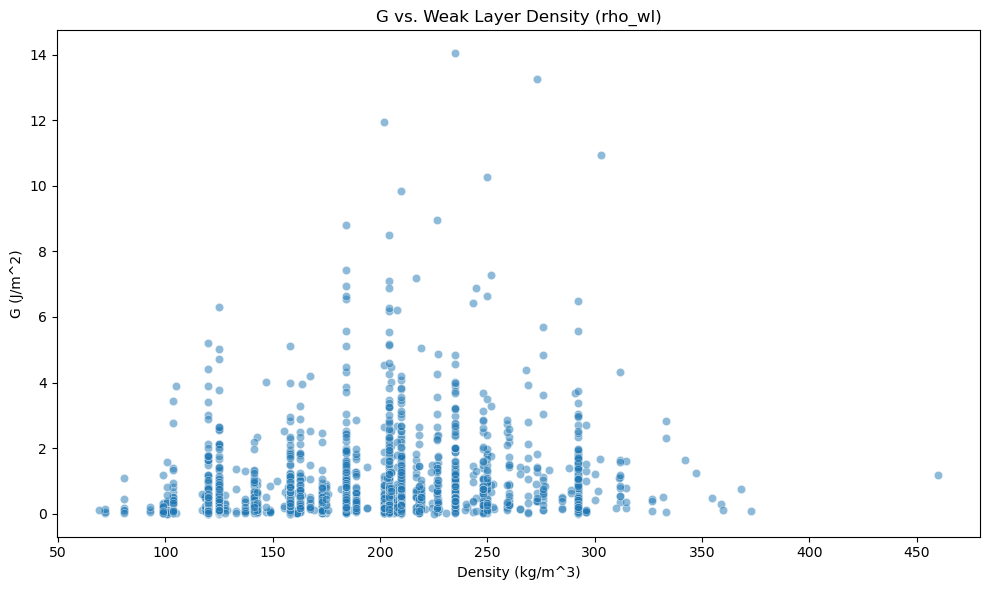

In [54]:
# Scatter plot of rho vs. GIc
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="rho_wl", y="G", alpha=0.5)
plt.title("G vs. Weak Layer Density (rho_wl)")
plt.xlabel("Density (kg/m^3)")
plt.ylabel("G (J/m^2)")
plt.tight_layout()

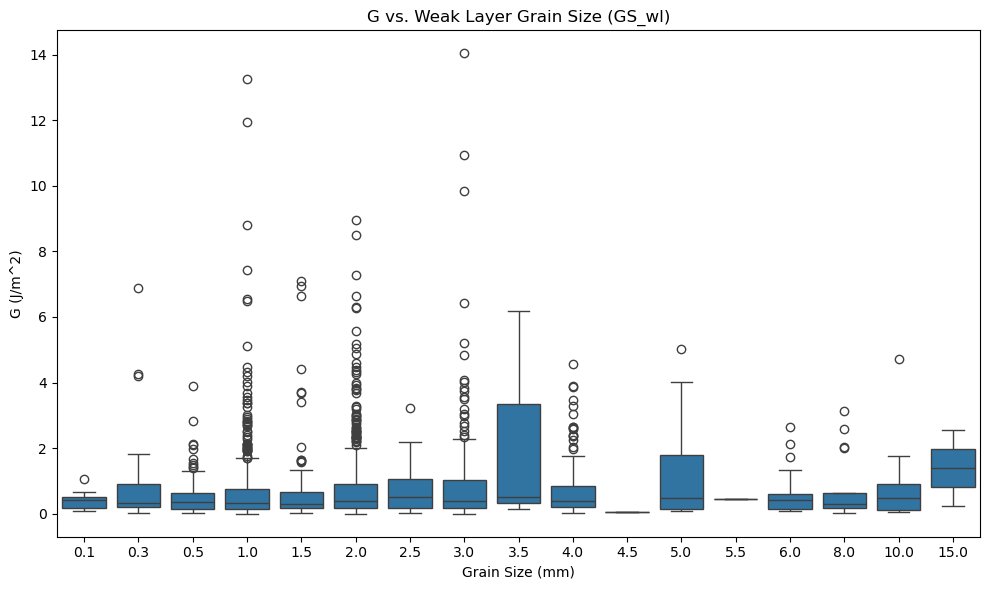

In [55]:
# Boxplot Grain Size vs. G
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="GS_wl", y="G")
plt.title("G vs. Weak Layer Grain Size (GS_wl)")
plt.xlabel("Grain Size (mm)")
plt.ylabel("G (J/m^2)")
plt.tight_layout()

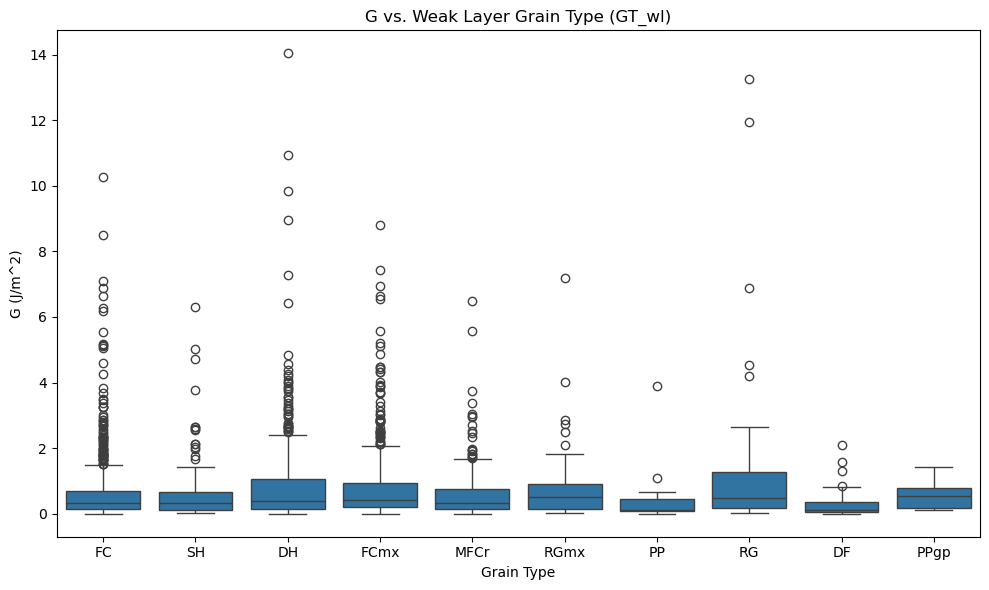

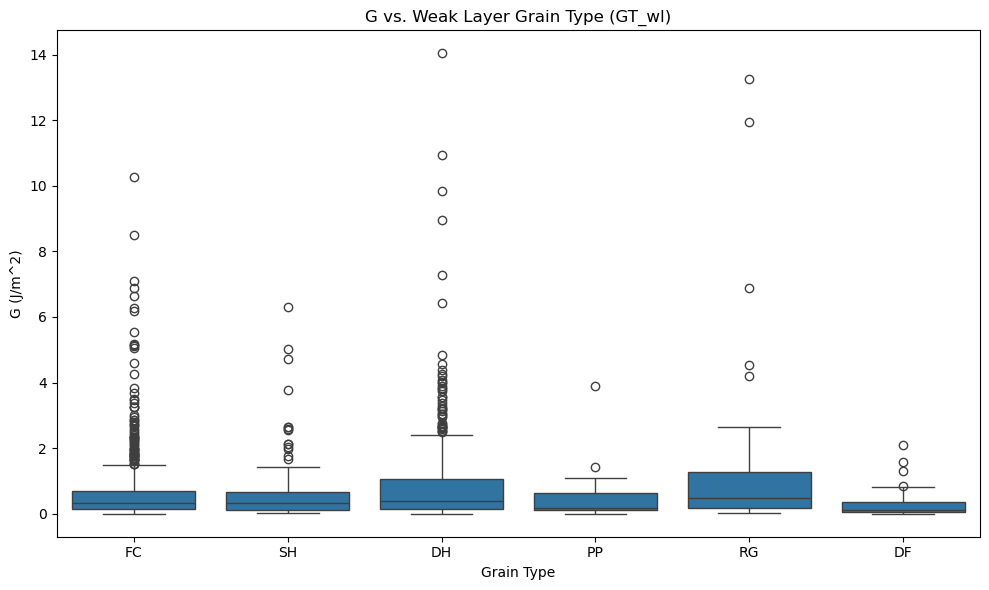

In [57]:
# Map SnowPilot grain type to those we know
GRAIN_TYPES = {
    "": "!skip",
    "DF": "DF",
    "DFbk": "DF",
    "DFdc": "DF",
    "DH": "DH",
    "DHch": "DH",
    "DHcp": "DH",
    "DHla": "DH",
    "DHpr": "DH",
    "DHxr": "DH",
    "FC": "FC",
    "FCsf": "FC",
    "FCso": "FC",
    "FCxr": "FC",
    "IF": "MFCr",
    "IFbi": "MFCr",
    "IFic": "MFCr",
    "IFil": "MFCr",
    "IFrc": "MFCr",
    "IFsc": "MFCr",
    "MF": "MFCr",
    "MFcl": "MFCr",
    "MFcr": "MFCr",
    "MFpc": "MFCr",
    "MFsl": "MFCr",
    "PP": "PP",
    "PPco": "PP",
    "PPgp": "PP",
    "gp": "PP",
    "PPhl": "PP",
    "PPip": "PP",
    "PPir": "PP",
    "PPnd": "PP",
    "PPpl": "PP",
    "PPrm": "PP",
    "PPsd": "PP",
    "RG": "RG",
    "RGlr": "RG",
    "RGsr": "RG",
    "RGwp": "RG",
    "RGxf": "RG",
    "SH": "SH",
    "SHcv": "SH",
    "SHsu": "SH",
    "SHxr": "SH",
    "WG": "WG",
}

# Box plot of Grain Type vs. G
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="GT_wl", y="G")
plt.title("G vs. Weak Layer Grain Type (GT_wl)")
plt.xlabel("Grain Type")
plt.ylabel("G (J/m^2)")
plt.tight_layout()

# Bin grain type according to GRAINTYPES
df["GT_wl"] = df["GT_wl"].map(GRAIN_TYPES)

# Boxplot Grain Type vs. G
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="GT_wl", y="G")
plt.title("G vs. Weak Layer Grain Type (GT_wl)")
plt.xlabel("Grain Type")
plt.ylabel("G (J/m^2)")
plt.tight_layout()